## 10: PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will teach you to use pytorch low-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [137]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

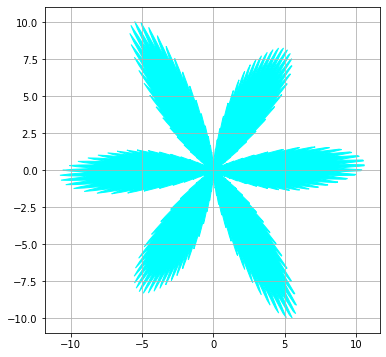

In [138]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + .9 * torch.cos(6*theta))\
      * (1 + .01 * torch.cos(24*theta))\
      * (.5 + .05* torch.cos(200*theta))\
      * (10 + torch.sin(10*theta))
### YOUR CODE HERE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho*torch.cos(theta)### YOUR CODE HERE
y = rho*torch.sin(theta)### YOUR CODE HERE


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='aqua')
plt.grid()

### Task 2: Using the Dataloader

In [139]:
from torch import nn
from torch.nn import functional as F

In [140]:
# !wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py

In [141]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [142]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [143]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [144]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [145]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

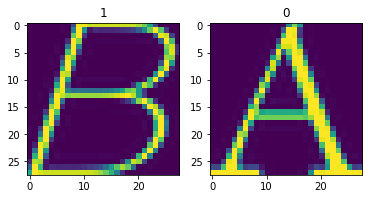

In [146]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [147]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [148]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [149]:
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


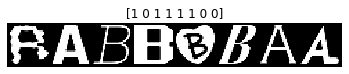

In [150]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [151]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [152]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [153]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


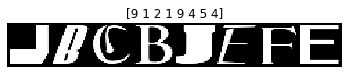

In [154]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [155]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [156]:
a = Flatten()

In [157]:
a(img).shape

torch.Size([784])

In [158]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [159]:
import time

from IPython.display import clear_output

In [160]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [164]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), int(ratio * len(dataset)), replace = False) ### YOUR CODE HERE

In [165]:
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [166]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

training size: 2996
validation size: 748


In [167]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [168]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [169]:
loss_func = nn.CrossEntropyLoss()

In [170]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [174]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            predict = model(X_batch)

            loss = loss_fn(predict, y_batch)

            loss.backward()
            opt.step()
            opt.zero_grad() ### <<< Here u r training
            ### YOUR CODE HERE

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            ep_train_loss.append(loss.item()) #Incase u have an error remove the item() part
            
            #.item( transforms from torch to python because at first we worked with GPU and we had to bring it back to CPU)

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predict_1 = model(X_batch)
                loss_1 = loss_fn(predict_1, y_batch)
                

                ### YOUR CODE HERE
                
                # compute predictions
                ### YOUR CODE HERE
                ep_val_loss.append(loss_1)### YOUR CODE HERE)
                y_pred = predict_1.max(1)[1].data  ### YOUR CODE HERE
                ep_val_accuracy.append((y_pred == y_batch).to(torch.float32).mean().item())### YOUR CODE HERE)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [175]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.236s
	  training loss: 1.700721
	validation loss: 1.692754
	validation accuracy: 0.845
Epoch 2 of 30 took 0.176s
	  training loss: 1.663788
	validation loss: 1.670774
	validation accuracy: 0.855
Epoch 3 of 30 took 0.214s
	  training loss: 1.646420
	validation loss: 1.655930
	validation accuracy: 0.860
Epoch 4 of 30 took 0.173s
	  training loss: 1.633257
	validation loss: 1.648578
	validation accuracy: 0.860
Epoch 5 of 30 took 0.206s
	  training loss: 1.624294
	validation loss: 1.645635
	validation accuracy: 0.866
Epoch 6 of 30 took 0.170s
	  training loss: 1.616897
	validation loss: 1.643330
	validation accuracy: 0.862
Epoch 7 of 30 took 0.208s
	  training loss: 1.610301
	validation loss: 1.639430
	validation accuracy: 0.865
Epoch 8 of 30 took 0.169s
	  training loss: 1.605151
	validation loss: 1.635416
	validation accuracy: 0.870
Epoch 9 of 30 took 0.199s
	  training loss: 1.601214
	validation loss: 1.637255
	validation accuracy: 0.863
Epoch 10 of 30 took 0.182s
	

In [176]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

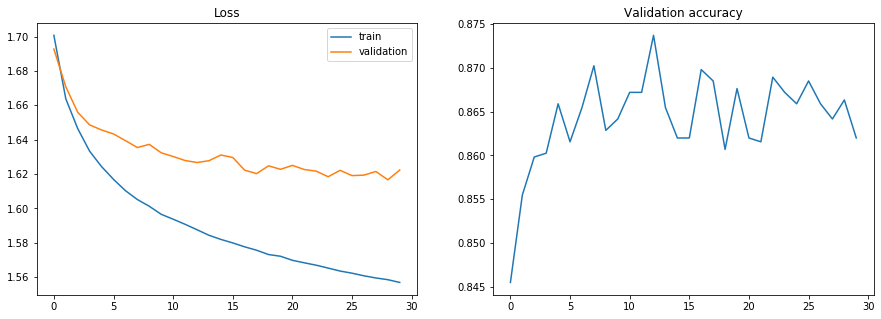

In [177]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [178]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [179]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.897s
	  training loss: 1.719023
	validation loss: 1.610882
	validation accuracy: 0.822
Epoch 2 of 30 took 0.790s
	  training loss: 1.576013
	validation loss: 1.572592
	validation accuracy: 0.873
Epoch 3 of 30 took 0.786s
	  training loss: 1.551720
	validation loss: 1.574302
	validation accuracy: 0.881
Epoch 4 of 30 took 0.788s
	  training loss: 1.535553
	validation loss: 1.565304
	validation accuracy: 0.890
Epoch 5 of 30 took 0.969s
	  training loss: 1.530434
	validation loss: 1.563072
	validation accuracy: 0.878
Epoch 6 of 30 took 0.807s
	  training loss: 1.521594
	validation loss: 1.563300
	validation accuracy: 0.897
Epoch 7 of 30 took 0.766s
	  training loss: 1.520989
	validation loss: 1.556153
	validation accuracy: 0.887
Epoch 8 of 30 took 0.750s
	  training loss: 1.515785
	validation loss: 1.554034
	validation accuracy: 0.890
Epoch 9 of 30 took 0.794s
	  training loss: 1.505923
	validation loss: 1.554593
	validation accuracy: 0.903
Epoch 10 of 30 took 0.776s
	

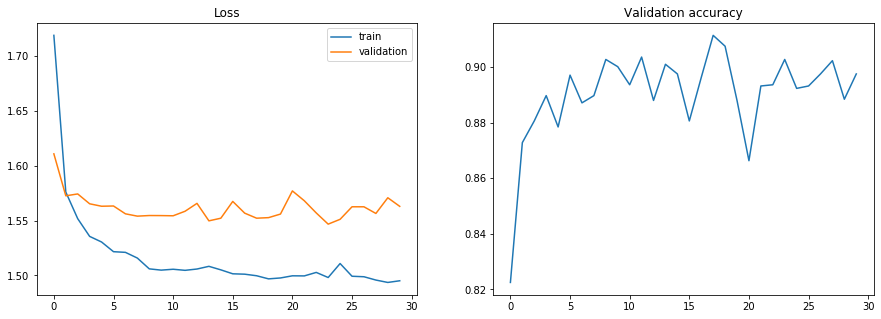

In [180]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Overfit!!!

In [187]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [188]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 1.754s
	  training loss: 1.751617
	validation loss: 1.674158
	validation accuracy: 0.694
Epoch 2 of 30 took 1.689s
	  training loss: 1.637982
	validation loss: 1.637584
	validation accuracy: 0.681
Epoch 3 of 30 took 1.695s
	  training loss: 1.628156
	validation loss: 1.641075
	validation accuracy: 0.719
Epoch 4 of 30 took 1.681s
	  training loss: 1.621941
	validation loss: 1.662677
	validation accuracy: 0.766
Epoch 5 of 30 took 1.696s
	  training loss: 1.643256
	validation loss: 1.667132
	validation accuracy: 0.691
Epoch 6 of 30 took 1.671s
	  training loss: 1.621975
	validation loss: 1.656914
	validation accuracy: 0.726
Epoch 7 of 30 took 2.044s
	  training loss: 1.631047
	validation loss: 1.641252
	validation accuracy: 0.791
Epoch 8 of 30 took 2.044s
	  training loss: 1.647122
	validation loss: 1.673284
	validation accuracy: 0.749
Epoch 9 of 30 took 2.390s
	  training loss: 1.639057
	validation loss: 1.669225
	validation accuracy: 0.701
Epoch 10 of 30 took 2.322s
	

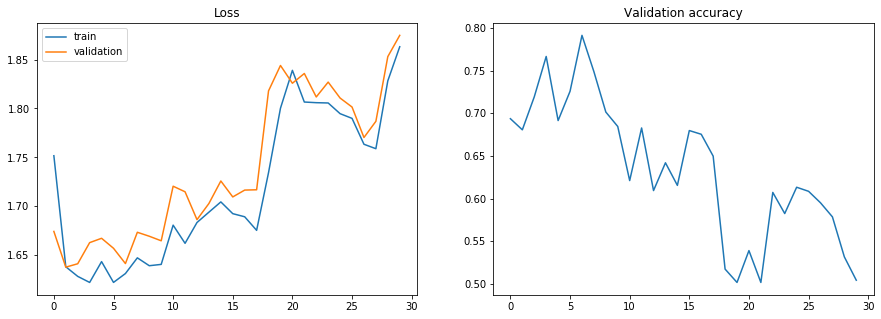

In [189]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

In [191]:
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 400),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [192]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 1.869s
	  training loss: 1.815296
	validation loss: 1.666290
	validation accuracy: 0.722
Epoch 2 of 30 took 1.821s
	  training loss: 1.671417
	validation loss: 1.646921
	validation accuracy: 0.749
Epoch 3 of 30 took 1.838s
	  training loss: 1.660873
	validation loss: 1.651834
	validation accuracy: 0.732
Epoch 4 of 30 took 1.704s
	  training loss: 1.653684
	validation loss: 1.641993
	validation accuracy: 0.732
Epoch 5 of 30 took 1.764s
	  training loss: 1.649620
	validation loss: 1.649357
	validation accuracy: 0.717
Epoch 6 of 30 took 1.863s
	  training loss: 1.647648
	validation loss: 1.634392
	validation accuracy: 0.716
Epoch 7 of 30 took 2.308s
	  training loss: 1.660397
	validation loss: 1.663905
	validation accuracy: 0.678
Epoch 8 of 30 took 2.399s
	  training loss: 1.657018
	validation loss: 1.678148
	validation accuracy: 0.699
Epoch 9 of 30 took 2.260s
	  training loss: 1.673393
	validation loss: 1.644009
	validation accuracy: 0.723
Epoch 10 of 30 took 2.172s
	

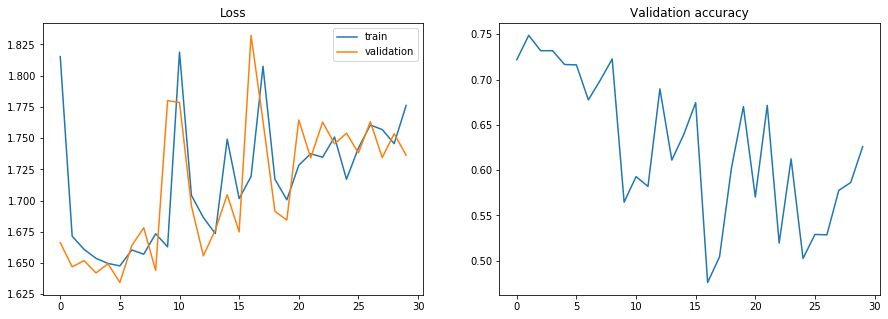

In [193]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Batchnorm try

In [198]:
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.BatchNorm1d(600),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 400),
    nn.ReLU(),
    nn.BatchNorm1d(400),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [199]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 3.151s
	  training loss: 1.715047
	validation loss: 1.593884
	validation accuracy: 0.858
Epoch 2 of 30 took 3.255s
	  training loss: 1.581132
	validation loss: 1.589735
	validation accuracy: 0.878
Epoch 3 of 30 took 2.779s
	  training loss: 1.561845
	validation loss: 1.584065
	validation accuracy: 0.850
Epoch 4 of 30 took 3.089s
	  training loss: 1.552562
	validation loss: 1.576124
	validation accuracy: 0.862
Epoch 5 of 30 took 2.993s
	  training loss: 1.548414
	validation loss: 1.588509
	validation accuracy: 0.849
Epoch 6 of 30 took 2.897s
	  training loss: 1.532058
	validation loss: 1.564303
	validation accuracy: 0.882
Epoch 7 of 30 took 2.913s
	  training loss: 1.531837
	validation loss: 1.563022
	validation accuracy: 0.878
Epoch 8 of 30 took 2.878s
	  training loss: 1.529576
	validation loss: 1.568457
	validation accuracy: 0.883
Epoch 9 of 30 took 2.906s
	  training loss: 1.527026
	validation loss: 1.565055
	validation accuracy: 0.886
Epoch 10 of 30 took 2.863s
	

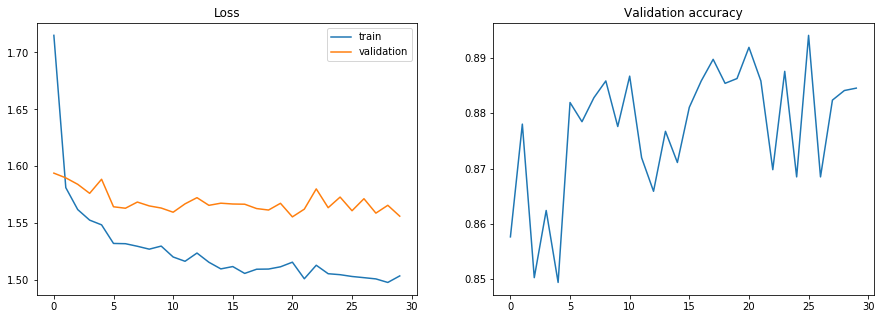

In [200]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [201]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [207]:
from torch.optim import SGD

# create a brand new model
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.BatchNorm1d(600),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 400),
    nn.ReLU(),
    nn.BatchNorm1d(400),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

NameError: name 'test' is not defined

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)